In [1]:
import numpy as np
import math
from scipy import interpolate
from scipy.stats import linregress
import matplotlib.pyplot as plt
import matplotlib
import bspline
import bspline.splinelab

In [2]:
splev_res = 1000

def gdk(z, n, k):
    zt = z[1:-1]
    t = []
    for i in range(n):
        t.append(zt[round((len(zt)-1)*(i+1)/(n+1))])
        
    t = np.concatenate(([z.min()]*(k+1), t, [z.max()]*(k+1)))
    return t

def softmax(w):
    w=np.exp(w)
    w/=w.sum()
    return w

def getSpeedVector(x, double=False):
    m = len(x)
    if len(x.shape) < 2:
        x = np.expand_dims(x,1)
    d = np.sqrt(((x[1:]-x[:-1])**2).sum(axis=1))
    z = []
    zsum = 0
    for i in range(len(x)):
        z.append(zsum)
        if i < m-1:
            if double:
                zsum += d[i]/2
                z.append(zsum)
                zsum += d[i]/2
            else:
                zsum += d[i]
    return np.array(z)

def generateUniformKnotVector(n,k):
    t = np.linspace(0,1,n+2)
    t = np.concatenate(([0]*k, t, [1]*k)) #n+2k+2
    return t

def generateDistKnotVector(x, n, k):
    z = getSpeedVector(x)
    z /= z[-1]
    z = z[1:-1]
    t = []
    for i in range(n):
        t.append(z[round((len(z)-1)*(i+1)/(n+1))])
        
    t = np.concatenate(([0]*(k+1), t, [1]*(k+1)))
    return t

def generateKnot(knotStrategy,x,n,k):
    if knotStrategy == 0:
        t = generateDistKnotVector(x,n,k)
    elif knotStrategy == 1:
        t = generateUniformKnotVector(n,k)
    return t
    
def vieta_formula(roots, n):
    # Initialize an array for polynomial coefficients
    coeff = [0] * (n + 1)
    # Set the highest order coefficient as 1
    coeff[0] = 1
 
    for i in range(n):
        for j in range(i + 1, 0, -1):
            coeff[j] += roots[i] * coeff[j - 1]
            
    return coeff[::-1]
    
def constructSmoothingMatrix(t,n,k):
    AT = np.zeros((n+k+1,n))
    for j in range(n):
        for i in range(k+n+1):
            if i<j+1 or i>j+k+1:
                AT[i][j] = 0
            else:
                roots = np.array(t[i:i+k+2])
                roots = -roots
                # Call the vieta_formula function
                coeffs = vieta_formula(roots, len(roots))
                pi_prime = 0
                for ri in range(1,len(roots)+1):
                    pi_prime += coeffs[ri]*(t[j+k+1]**(ri-1))*ri
                
                #print(i,j, i+1, i-k, len(t), t[j], pi_prime)
                #print(math.factorial(k),(t[i+k+1]-t[i]),pi_prime, t[j+k+1], roots, coeffs)
                AT[i][j] = math.factorial(k)*(t[i+k+1]-t[i])/pi_prime
    return AT.T

def constructSecondDerMatrix(x):
    m = len(x)
    h = x[1:]-x[:-1]
    Q = np.zeros((m,m-2))
    R = np.zeros((m-2,m-2))
    for i in range(m-2):
        Q[i][i] = 1/h[i]
        Q[i+1][i] = -(1/h[i]+1/h[i+1])
        Q[i+2][i] = 1/h[i+1]
        R[i][i] = (h[i]+h[i+1])/3
        if i < m-3:
            R[i+1][i] = R[i][i+1] = h[i+1]/6
            
    return Q @ np.linalg.inv(R) @ Q.T

In [3]:
def get_proj_idx(path_1, path_2, clean=False):
    idx = np.array([np.linalg.norm(path_2-p, axis=1).argmin() for p in path_1])
    if clean:
        idx = np.unique(idx)
        idx.sort()
        
    return idx

def get_path_by_idx(path, idx):
    return [path[i] for i in idx]

def getProj(p1,p2):
    idx1 = get_proj_idx(p2,p1, clean=True)
    proj1 = np.array(get_path_by_idx(p1,idx1))
    
    idx2 = get_proj_idx(proj1,p2)
    proj2 = np.array(get_path_by_idx(p2,idx2))

    return proj1, proj2, idx1, idx2

In [4]:
def FitSpline(path,k,lm,clamp=True):
    cn = len(path)
    z = getSpeedVector(path)
    t = gdk(z,cn-k-1,k)
    bs = bspline.Bspline(t, k)
    B = np.array([bs._Bspline__basis(zi,k) for zi in z])
    B[-1][-1] = 1
    K=constructSecondDerMatrix(z)
    m = len(path)
    
    eqn = 2
    P = np.zeros((eqn, cn))
    q = np.zeros((eqn,2))

    if clamp:
        P[0][0] = P[-1][-1] = 1
        q[0] = path[0]
        q[1] = path[-1]
    
    LHS = np.concatenate((np.concatenate((((1-lm)*(B.T @ B))+(lm*((B).T@K@(B))),P.T),axis=1), np.concatenate((P, np.zeros((P.shape[0],P.shape[0]))), axis=1)), axis=0)
    RHS = np.concatenate(((1-lm)*(B.T @ path), q),axis=0)
    cz = np.linalg.pinv(LHS) @ RHS
    c = cz[:cn]
    
    return (t,c.T,k), z

def FitSplineWithAngleConstraint(path,k,lm,lm2,angle_index, theta, w=None, clamp=True):
    cn = len(path)
    if w is None:
        w=[1]*cn
        w = np.exp(w)
        w/=w.sum()
    
    w = np.tile(w,2)
    w = np.expand_dims(w,1)
        
    z = getSpeedVector(path)
    t = gdk(getSpeedVector(path, double=True),cn-k-1,k)
    t = gdk(z,cn-k-1,k)
    bs = bspline.Bspline(t, k)
    B = np.array([bs._Bspline__basis(zi,k) for zi in z])
    B[-1][-1] = 1
    K=constructSecondDerMatrix(z)
    m = len(path)
    
    Bp = np.concatenate((np.concatenate((B,np.zeros((m,cn))), axis=1), np.concatenate((np.zeros((m,cn)),B), axis=1)), axis=0)
    Bp = np.concatenate((Bp, np.zeros((2*cn,1))),axis=1)

    Kp = np.concatenate((np.concatenate((K,np.zeros((m,m))), axis=1), np.concatenate((np.zeros((m,m)),K), axis=1)), axis=0)
    
    eqn = 4
    P = np.zeros((eqn, 2*cn+1))
    q = np.zeros((eqn,1))

    if clamp:
        P[0][0] = P[1][cn-1] = P[2][cn] = P[3][2*cn-1] = 1
        q[0] = path[0][0]
        q[1] = path[-1][0]
        q[2] = path[0][1]
        q[3] = path[-1][1]
    
    u = z[angle_index]
    bs_d = bspline.Bspline(t[1:-1], k-1)
    b_d = bs_d._Bspline__basis(u,k-1)
    d = np.concatenate(([-b_d[0]*k/(t[k+1]-t[1])],[b_d[i-1]*k/(t[i+k]-t[i])-b_d[i]*k/(t[i+k+1]-t[i+1]) for i in range(1,cn-1)], [b_d[cn-2]*k/(t[k+cn-1]-t[cn-1])]),axis=0)
    
    D = np.vstack((np.concatenate((d,np.zeros(d.shape)),axis=0),np.concatenate((np.zeros(d.shape),d),axis=0)))
    D = np.concatenate((D,np.array([[-np.cos(theta)], [-np.sin(theta)]])), axis=1)
    
    LHS = np.concatenate((np.concatenate(((1-lm2)*((1-lm)*((w*Bp).T @ (w*Bp))+lm*((Bp).T@Kp@(Bp)))+lm2*(D.T@D),P.T),axis=1), np.concatenate((P, np.zeros((P.shape[0],P.shape[0]))), axis=1)), axis=0)
    RHS = np.concatenate(((1-lm2)*(1-lm)*((w*Bp).T @ (w*path.T.reshape(2*len(path),1))), q),axis=0)
    cz = np.linalg.pinv(LHS) @ RHS
    c = cz[:2*cn+1]
    
    r = c[-1]
    c = c[:-1].reshape(2,cn)
    t = (t-z.min())/(z.max()-z.min())

    d=np.expand_dims(d,0)
    print(d.shape,c.shape)
    der=(d@c.T)[0]
    th = np.arctan(der[1]/der[0])
    return (t,c,k), z
    
    d=np.expand_dims(d,0)
    s_derv = np.array(interpolate.splev([u],(t,c.T,k)))
    der = (d@c)[0]
    der_norm = np.linalg.norm(der)
    if(der_norm > 0):
        der /= der_norm
    e_derv = np.expand_dims(der,0)
    plt.arrow(*[i[0] for i in s_derv], *[i[0] for i in e_derv.T], color='tab:green', shape='full', head_width=0.1, width=0.01)
    
    x = np.linspace(z.min(), z.max(), splev_res+1)
    yimpl = interpolate.splev(x,(t,c.T,k))
    plt.scatter(path[:,0], path[:,1],color='black',label='data',s=10)
    #plt.scatter(*c.T,s=10, color='orange', label='controls')
    plt.plot(*yimpl, label='spline')
    plt.grid()
    plt.legend()
    plt.show()

In [17]:
def MergePaths(p1,p2,i1,i2,theta,k=3):
    proj1, proj2, idx1, idx2 = getProj(p1,p2)
    i12 = idx1.min()
    n1 = np.max(i1-i12,0)
    i21 = min(idx2.min()+n1, i2)

    path = np.concatenate((p1[:i1], p2[i21:]))
    w = np.concatenate(([1]*i1, np.linspace(0,1,i2-i21) if i2>i21 else [], [1]*(len(p2)-i2)))
    w = np.exp(w)
    w /= w.sum()

    tck_new,_ = FitSplineWithAngleConstraint(path,k,0.05,0.5,i1+i2-i21,theta,w=w,clamp=True)

    return tck_new 

In [600]:
np.array([[2,3]]).T*np.array([[1,2,3],[2,3,4]])

(2, 1)

In [598]:
np.expand_dims(w,1).shape

(48, 1)

In [580]:
np.tile(w,2)

array([0.02216494, 0.02216494, 0.02216494, 0.02216494, 0.02216494,
       0.02216494, 0.02216494, 0.02216494, 0.02216494, 0.02216494,
       0.02216494, 0.02216494, 0.02216494, 0.02216494, 0.02216494,
       0.02216494, 0.02216494, 0.02216494, 0.02216494, 0.02216494,
       0.00815402, 0.0094062 , 0.01085066, 0.01251694, 0.0144391 ,
       0.01665645, 0.01921429, 0.02216494, 0.02216494, 0.02216494,
       0.02216494, 0.02216494, 0.02216494, 0.02216494, 0.02216494,
       0.02216494, 0.02216494, 0.02216494, 0.02216494, 0.02216494,
       0.02216494, 0.02216494, 0.02216494, 0.02216494, 0.02216494,
       0.02216494, 0.02216494, 0.02216494, 0.02216494, 0.02216494,
       0.02216494, 0.02216494, 0.02216494, 0.02216494, 0.02216494,
       0.02216494, 0.02216494, 0.02216494, 0.02216494, 0.02216494,
       0.02216494, 0.02216494, 0.02216494, 0.02216494, 0.02216494,
       0.02216494, 0.02216494, 0.02216494, 0.00815402, 0.0094062 ,
       0.01085066, 0.01251694, 0.0144391 , 0.01665645, 0.01921

In [299]:
x1 = np.arange(0,20,0.5)
y1 = 9*(x1**0.4)

x2 = np.arange(5,30,0.5)
y2 = 9*(x2**0.3)

p1 = np.array([x1,y1]).T
p2 = np.array([x2,y2]).T
#p1 += np.random.normal(0,0.1,p1.shape)
#p2 += np.random.normal(0,0.1,p2.shape)

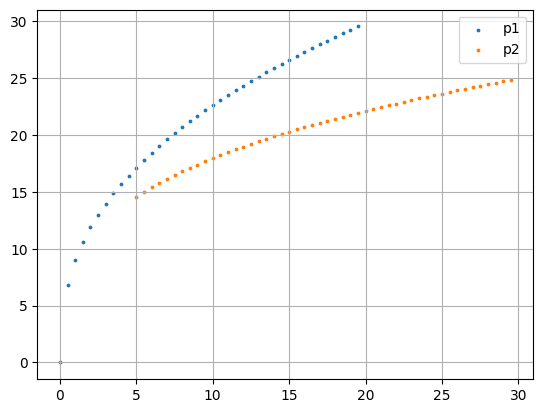

In [301]:
plt.scatter(*p1.T, label='p1', s=3)
plt.scatter(*p2.T, label='p2', s=3)
plt.legend()
plt.grid()
xl,yl = plt.xlim(), plt.ylim()
plt.show()

In [332]:
p1_spline_tck,z1 = FitSpline(p1,3,0.5)
p1_spline = interpolate.splev(np.linspace(0,1,len(p1)),p1_spline_tck)

p2_spline_tck,z2 = FitSpline(p2,3,0.5)
p2_spline = interpolate.splev(np.linspace(0,1,len(p2)),p2_spline_tck)

dx,dy=interpolate.splev([z2[i2]],p2_spline_tck,der=1)
theta=np.arctan(dy/dx).item()

In [352]:
dx,dy=interpolate.splev([z2[i2]],p2_spline_tck,der=1)
theta=np.arctan(dy/dx).item()

In [340]:
i1,i2 = 20,20

In [538]:
#p2_i1 = np.array([np.linalg.norm(p-p1[i1]) for p in p2]).argmin()
proj1, proj2, idx1, idx2 = getProj(p1,p2)
pi1 = np.array([np.linalg.norm(p1[i1]-proj1[i]) for i in range(len(proj1))]).argmin()
p2_i1 = idx2.min()+pi1

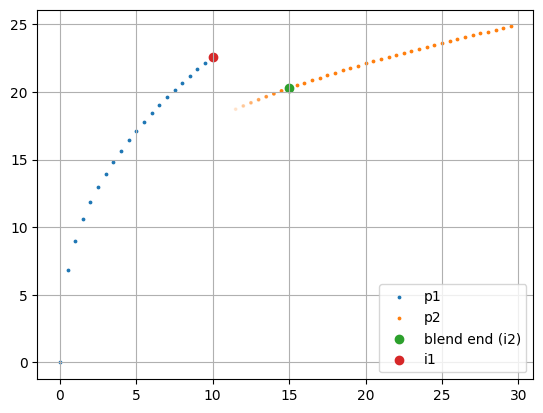

In [540]:
plt.scatter(*p1[:i1].T, label='p1', s=3)
plt.scatter(*p2[p2_i1:i2].T, s=3, alpha=np.linspace(0,1,i2-p2_i1), color='tab:orange')
plt.scatter(*p2[i2:].T, label='p2', s=3, color='tab:orange')
plt.scatter(*p2[i2], color='tab:green', label='blend end (i2)')
plt.scatter(*p1[i1], color='tab:red', label='i1')
plt.legend()
plt.grid()
xl,yl = plt.xlim(), plt.ylim()
plt.show()

In [522]:
p2_i1 = idx2.min() #np.array([np.linalg.norm(p-p1[i1]) for p in p2]).argmin()
path = np.concatenate((p1[:i1], p2[min(p2_i1, i2):]))
w = np.concatenate(([1]*i1, np.linspace(0,1,i2-p2_i1) if i2>p2_i1 else [], [1]*i2))
w = np.exp(w)
w /= w.sum()

NameError: name 'idx2' is not defined

(58,) (2, 58)
(1, 58) (2, 58)
-29.954580395610833


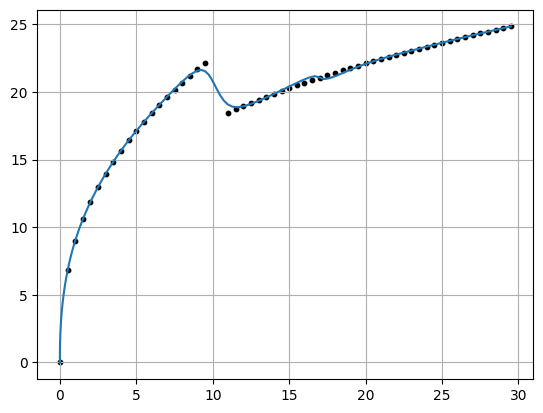

In [664]:
tck_new,_ = FitSplineWithAngleConstraint(path,k,0.5,0.5,i1+p2_i1,-30/180*np.pi,clamp=True)
y = interpolate.splev(np.linspace(0,1,101),tck_new)
plt.plot(*y)
plt.scatter(*path.T, color='black',s=10)
plt.grid()
plt.show()

In [606]:
path.shape

(58, 2)

In [694]:
p1_spline_tck,z1 = FitSpline(p1,3,0.5)
p1_spline = interpolate.splev(np.linspace(0,1,len(p1)),p1_spline_tck)

p2_spline_tck,z2 = FitSpline(p2,3,0.5)
p2_spline = interpolate.splev(np.linspace(0,1,len(p2)),p2_spline_tck)

dx,dy=interpolate.splev([z2[i2]],p2_spline_tck,der=1)
theta=np.arctan(dy/dx).item()

(1, 58) (2, 58)


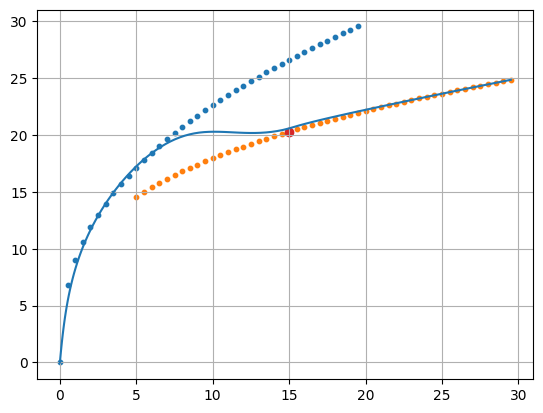

In [25]:
x1 = np.arange(0,20,0.5)
y1 = 9*(x1**0.4)

x2 = np.arange(5,30,0.5)
y2 = 9*(x2**0.3)

p1 = np.array([x1,y1]).T
p2 = np.array([x2,y2]).T
#p1 += np.random.normal(0,0.1,p1.shape)
#p2 += np.random.normal(0,0.1,p2.shape)

i1,i2 = 20,20
p1_spline_tck,z1 = FitSpline(p1,3,0.5)
p1_spline = interpolate.splev(np.linspace(0,1,len(p1)),p1_spline_tck)
p2_spline_tck,z2 = FitSpline(p2,3,0.5)
p2_spline = interpolate.splev(np.linspace(0,1,len(p2)),p2_spline_tck)

dx,dy=interpolate.splev([z2[i2]],p2_spline_tck,der=1)
theta=np.arctan(dy/dx).item()

tck_new = MergePaths(p1,p2,i1,i2,theta)
y = interpolate.splev(np.linspace(0,1,101),tck_new)
plt.plot(*y)
plt.scatter(*p1.T, color='tab:blue',s=10)
plt.scatter(*p2.T, color='tab:orange',s=10)
plt.scatter(*p2[i2], color='tab:red')
plt.grid()
plt.show()

In [702]:
i1,i2 = 20,20
proj1, proj2, idx1, idx2 = getProj(p1,p2)
i12 = idx1.min()
n1 = np.max(i1-i12,0)
i21 = min(idx2.min()+n1, i2)

In [704]:
#p2_i1 = np.array([np.linalg.norm(p-p1[i1]) for p in p2]).argmin()
path = np.concatenate((p1[:i1], p2[i21:]))
w = np.concatenate(([1]*i1, np.linspace(0,1,i2-i21) if i2>p2_i1 else [], [1]*(len(p2)-i2)))
w = np.exp(w)
w /= w.sum()

(58,) (2, 58)
(1, 58) (2, 58)
21.53283861069659


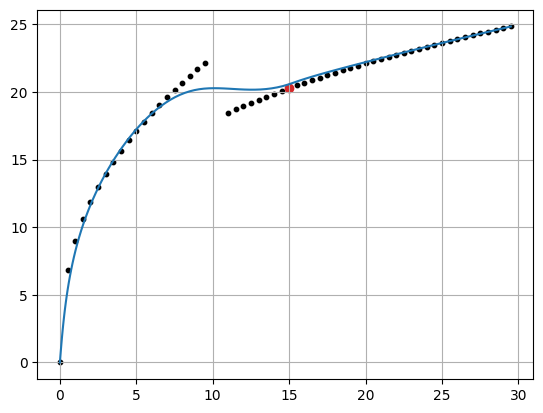

In [706]:
tck_new,_ = FitSplineWithAngleConstraint(path,k,0.05,0.5,i1+i2-p2_i1,theta,w=w,clamp=True)
y = interpolate.splev(np.linspace(0,1,101),tck_new)
plt.plot(*y)
plt.scatter(*path.T, color='black',s=10)
plt.scatter(*p2[i2], color='tab:red')
plt.grid()
plt.show()

((58,), (58, 2))

array([0.01814345, 0.01814345, 0.01814345, 0.01814345, 0.01814345,
       0.01814345, 0.01814345, 0.01814345, 0.01814345, 0.01814345,
       0.01814345, 0.01814345, 0.01814345, 0.01814345, 0.01814345,
       0.01814345, 0.01814345, 0.01814345, 0.01814345, 0.01814345,
       0.0066746 , 0.00769959, 0.00888198, 0.01024594, 0.01181935,
       0.01363439, 0.01572816, 0.01814345, 0.01814345, 0.01814345,
       0.01814345, 0.01814345, 0.01814345, 0.01814345, 0.01814345,
       0.01814345, 0.01814345, 0.01814345, 0.01814345, 0.01814345,
       0.01814345, 0.01814345, 0.01814345, 0.01814345, 0.01814345,
       0.01814345, 0.01814345, 0.01814345, 0.01814345, 0.01814345,
       0.01814345, 0.01814345, 0.01814345, 0.01814345, 0.01814345,
       0.01814345, 0.01814345, 0.01814345])